In [1]:
import utils as u
import numpy as np
import pickle
import matplotlib.pyplot as plt

#plt.rc('text', usetex=True)
#plt.rc('font', size = 10)
#plt.rc('font', family='serif')

%matplotlib widget

with open('modal_m1.pkl', 'rb') as f:
    modal_analysis_m1 = pickle.load(f)
modal_analysis_m1

{'table': 'Medium_1',
 'freq': array([ 75, 149, 160, 184, 268, 286, 319, 345, 427, 460, 515, 602, 654]),
 'xi': array([-0.00026   , -0.00017893, -0.000337  , -0.000808  , -0.000549  ,
        -0.000603  , -0.000752  , -0.000908  , -0.000219  , -0.000758  ,
        -0.001235  , -0.001077  , -0.000958  ]),
 'ratios': array([1.        , 1.98666667, 2.13333333, 2.45333333, 3.57333333,
        3.81333333, 4.25333333, 4.6       , 5.69333333, 6.13333333,
        6.86666667, 8.02666667, 8.72      ]),
 'xi_mod': array([-0.08874667, -0.03074233, -0.05392   , -0.11241739, -0.05244179,
        -0.05397483, -0.06034859, -0.06737623, -0.01312974, -0.04218435,
        -0.06139029, -0.04579934, -0.03749969])}

In [2]:
def calcul_e_nu(omega,Lx,Ly,rapport):
    return(rapport * omega**2 / (((np.pi/Lx)**2 + (np.pi/Ly)**2)**2)   )

def omega_pq (p,q,h,E_nu,rho,Lx,Ly) :    #Calcul analytique des pulsations propres d'une plaque en appuis simple
    return np.sqrt(E_nu*h**2/(12*rho)) * ((p*np.pi/Lx)**2+(q*np.pi/Ly)**2)

def phi_pq (p,q,x,y, Lx, Ly) :  #Calcul analytique des déformées des modes d'une plaque en appuis simple
    """
    ## Inputs
    - p : numéro du mode selon x
    - q : numéro du mode selon y
    - x : arrayLike, vecteur des abscisses
    - y : arrayLike, vecteur des ordonnées

    ## Outputs
    - phi_pq : arrayLike, size (Nx,Ny), déformée du mode (p,q) en tous les points (x,y) du maillage
    """
    return np.sin(p*np.pi*x[:,np.newaxis]/Lx)*np.sin(q*np.pi*y[np.newaxis,:]/Ly)

def f_plaque(Lx,Ly,h,E_nu,rhoT):
    NB, MB = 3, 3 #Nombre de modes selon x, y
    NmB = NB * MB   #Nombre de modes total considéré dans le modèle de plaque

    dx, dy = 10e-3, 10e-3
    x, y = np.arange(0,Lx,dx), np.arange(0,Ly,dy)
    Nx, Ny = len(x), len(y)
    X_plate, Y_plate = np.meshgrid(x, y)
    X_ravel, Y_ravel = np.ravel(X_plate), np.ravel(Y_plate)

    ## Calcul des modes

    wnB = np.zeros(NmB)
    NmB_idx = np.zeros((2,NmB))   #Cette liste permet de remonter du mode contracté "i" au mode réel (n_i,m_i) en appelant NmB_idx[:,i]
    j = 0
    for n in range(1,NB+1) :
        for m in range(1,MB+1) :
            wnB[j] = omega_pq(n,m, h, E_nu,rhoT,Lx,Ly)
            NmB_idx[0,j] = n
            NmB_idx[1,j] = m
            j += 1

    ### Tri par ordre de fréquences croissantes
    tri_idx = np.argsort(wnB)

    wnB = wnB[tri_idx]    #On range les pulsations par ordre croissant 

    return(wnB/2/np.pi)
def mode_plaque(Lx,Ly,h,E_nu,rhoT):
    NB, MB = 3, 3 #Nombre de modes selon x, y
    NmB = NB * MB   #Nombre de modes total considéré dans le modèle de plaque

    dx, dy = 10e-3, 10e-3
    x, y = np.arange(0,Lx,dx), np.arange(0,Ly,dy)
    Nx, Ny = len(x), len(y)
    X_plate, Y_plate = np.meshgrid(x, y)
    X_ravel, Y_ravel = np.ravel(X_plate), np.ravel(Y_plate)

    ## Calcul des modes

    wnB = np.zeros(NmB)
    NmB_idx = np.zeros((2,NmB))   #Cette liste permet de remonter du mode contracté "i" au mode réel (n_i,m_i) en appelant NmB_idx[:,i]
    j = 0
    for n in range(1,NB+1) :
        for m in range(1,MB+1) :
            wnB[j] = omega_pq(n,m, h, E_nu,rhoT,Lx,Ly)
            NmB_idx[0,j] = n
            NmB_idx[1,j] = m
            j += 1

    ### Tri par ordre de fréquences croissantes
    tri_idx = np.argsort(wnB)

    wnB = wnB[tri_idx]    #On range les pulsations par ordre croissant 
    NmB_idx = NmB_idx[:,tri_idx]      #On ordonne les modes par ordre croissant

    ### Déformées

    phiB_NxNy_NmB = np.zeros((Nx*Ny,NmB)) #Matrice des déformées avec les 2 dimensions spatiales applaties en 1 dimension
    for mode in range (NmB) :
        n, m = NmB_idx[0,mode], NmB_idx[1,mode]
        phiB_NxNy_NmB[:,mode] = phi_pq(n, m , x, y, Lx, Ly).ravel()

    return(wnB/2/np.pi,phiB_NxNy_NmB,x,y)

##phiB_NxNy_NmB[:,j],(Nx,Ny)

Lx = 0.40
Ly = 0.26

fond_m1 = 75
h_m1 = 2.95e-3 
masse_m1 = 236e-3
rho_m1 = masse_m1 / (Lx * Ly * h_m1)
Rapport_m1 = 12 * rho_m1 / h_m1**2
E_nu_m1 = calcul_e_nu(fond_m1*np.pi*2,Ly,Ly,Rapport_m1)

f_base,phiB_NxNy_NmB,x,y = mode_plaque(Lx,Ly,h_m1,E_nu_m1,rho_m1)
Nx = len(x)
Ny = len(y)

X_che1 = 13 
Y_che1 = 8

X_che2 = 19
Y_che2 = 11

from data_loader import *

idx_mat = 1 #Je choisis le matériau d'indice 1

dico_pos1 = deforme_Nta_Npos[idx_mat,0]
dico_pos2 = deforme_Nta_Npos[idx_mat,1]

freq1 = dico_pos1['freq']
FRF1 = dico_pos1['FRF']

freq2 = dico_pos2['freq']
FRF2 = dico_pos2['FRF']

f_fond = modal_analysis_m1['freq']

phiB_NxNy_NmB_zeros = np.zeros_like(phiB_NxNy_NmB)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/io/matlab/_mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


{'0': 'Metal', '1': 'Medium_1', '2': 'Plexi', '3': 'Medium_2'}


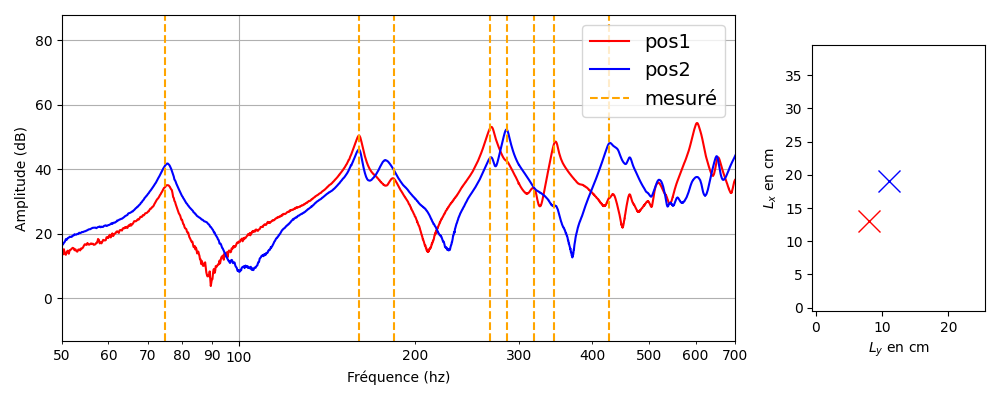

In [9]:
fig = plt.figure(figsize=(10,4))
a1 = plt.subplot2grid((1,4),(0,0),colspan = 3,rowspan = 1)
a2 = plt.subplot2grid((1,4),(0,3),colspan = 1,rowspan = 1)
a1.semilogx(freq1,20*np.log10(np.abs(FRF1)),'r',label='pos1')
a1.semilogx(freq2,20*np.log10(np.abs(FRF2)),'b',label='pos2')
a1.grid()
a1.set_xlim(50,700)
a1.set_xlabel("Fréquence (hz)")#,size=15)
a1.set_ylabel("Amplitude (dB)")#,size=15)
import matplotlib.ticker as mticker
a1.xaxis.set_minor_formatter(mticker.ScalarFormatter())
a1.xaxis.set_major_formatter(mticker.ScalarFormatter())

a1.axvline(f_fond[0],ls='--',color='orange',label='mesuré')
for i in range(2,min(len(f_fond),len(f_base))):
    a1.axvline(f_fond[i],ls='--',color='orange')
a1.legend(fontsize=14)

a2.imshow(np.reshape(1 + phiB_NxNy_NmB_zeros[:,0],(Nx,Ny)),cmap="binary",origin='lower')
a2.plot(Y_che1,X_che1,'rx',label='pos1',markersize='16')
a2.plot(Y_che2,X_che2,'bx',label='pos2',markersize='16')
a2.set_xlabel('$L_y$ en cm')#,size=15)
a2.set_ylabel('$L_x$ en cm')#,size=15)

#fig.set_size_inches(w=3.48715013889, h=3.2)

fig.tight_layout()
plt.show()

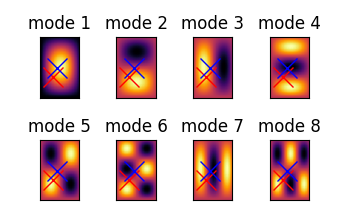

In [4]:
fig = plt.figure()
for i in range(4):
    ax = plt.subplot2grid((2,4),(0,i),rowspan = 1, colspan = 1)
    #if i == 0:
    #    ax.set_ylabel('L_x en cm',size=15)
    #ax.set_xlabel('L_y en cm',size=15)

    ax.imshow(np.reshape(phiB_NxNy_NmB[:,i],(Nx,Ny)),origin="lower",cmap="inferno")
    ax.plot(Y_che1,X_che1,'rx',label='pos1',markersize=15)
    ax.plot(Y_che2,X_che2,'bx',label='pos2',markersize=15)
    #ax.set_title(f'f: {f_base[i]:0.1f} Hz')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'mode {i+1}')
for i in range(4):
    ax = plt.subplot2grid((2,4),(1,i),rowspan = 1, colspan = 1)
    #if i == 0:
    #    ax.set_ylabel('L_x en cm',size=15)
    #ax.set_xlabel('L_y en cm',size=15)

    ax.imshow(np.reshape(phiB_NxNy_NmB[:,4+i],(Nx,Ny)),origin="lower",cmap="inferno")
    ax.plot(Y_che1,X_che1,'rx',label='pos1',markersize=15)
    ax.plot(Y_che2,X_che2,'bx',label='pos2',markersize=15)
    #ax.set_title(f'f: {f_base[i]:0.1f} Hz')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'mode {4+i+1}')
fig.set_size_inches(w=3.48715013889, h=2.2)

fig.tight_layout()
plt.tight_layout()
plt.show()